### Imports

In [1]:
from IPython.display import clear_output

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import keras
import keras.layers as layers
from keras import backend as K

import tensorflow as tf

C:\Users\Jon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [122]:
y_power = 6
n_y = 2**y_power

## Test a Distribution

<IPython.core.display.Javascript object>


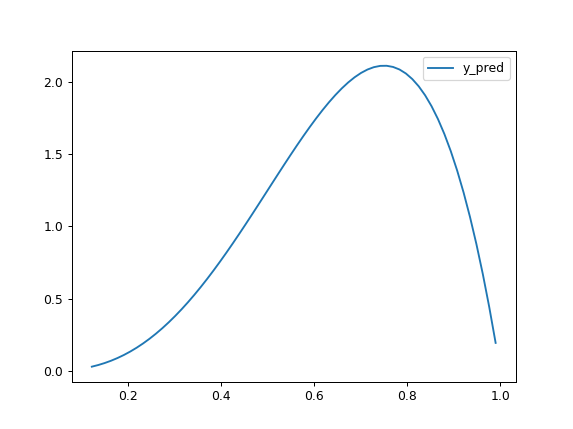

In [123]:
distribution = stats.beta
args = (4,2)
lim = (10**-3,10**-3)

y_x = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
y = distribution.pdf(y_x, *args)
      
plt.figure()
plt.plot(y_x, y, label='y_pred')
plt.legend()

## Dataset

### Select Distributions

In [124]:
set_distributions = [stats.norm, stats.t, stats.powernorm, stats.beta]
arg_placeholders = [list(), (None,), (None,), (None, None)]

In [125]:
distributions = list()
abs_power_lim = -4
lims = list()
distrib_args = list()
n_type = 2**9
for i in range(n_type):
    for distribution, args_placeholder in zip(set_distributions,arg_placeholders):        
        successful = False
        while not successful:
            abs1 = 10 ** (np.random.random() * abs_power_lim)
            abs2 = 10 ** (np.random.random() * abs_power_lim)
            args = tuple(np.random.randint(1,10) for _ in args_placeholder)
            x_1 = distribution.ppf(abs1, *args)
            x_2 = distribution.ppf(1-abs2, *args)
            if x_1 > -5 and x_2 < 5:
                lims.append((abs1,abs2))
                distrib_args.append(args)
                distributions.append(distribution)
                successful = True

### Generate Curves

In [126]:
y_x = np.nan * np.ones((len(distributions),n_y))
y_pdf = np.nan * np.ones((len(distributions),n_y))
for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
    y_x[i,:] = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
    y = distribution.pdf(y_x[i,:], *args)
    y.reshape((1, y.size))    
    y_pdf[i,:] = y
    
n_x = list(set([ j * 2**i for i in range(1,y_power) for j in (2,3,5)]))
n_x = np.array(n_x)
n_x.sort()
x_x_list = list()
x_pdf_list = list()
y_list = list()
for n in n_x:  
    x_x = np.nan * np.ones((len(distributions),n))
    x_pdf = np.nan * np.ones((len(distributions),n))
    for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
        x_x[i,:] = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
        x_pdf[i,:] = distribution.pdf(x_x[i,:],*args)
    x_x_list.append(x_x)
    x_pdf_list.append(x_pdf)

n_x: 6


<IPython.core.display.Javascript object>


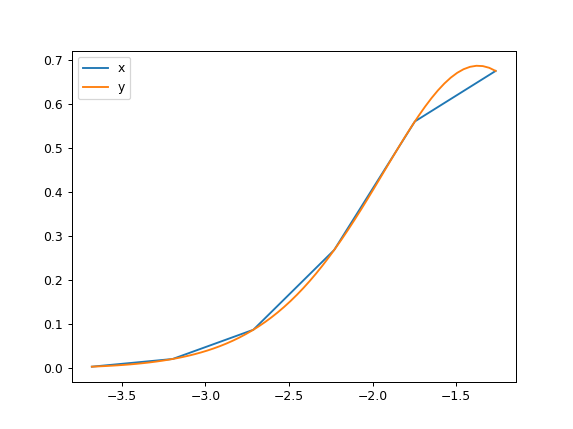

In [127]:
sample_index = 1
distribution_index = 210
print('n_x: {0}'.format(n_x[sample_index]))
plt.figure()
plt.plot(x_x_list[sample_index][distribution_index,:], 
         x_pdf_list[sample_index][distribution_index,:], label='x')
plt.plot(y_x[distribution_index,:], y_pdf[distribution_index,:], label='y')
plt.legend()

In [128]:
print('Individual Curves: {0}'.format(len(distributions)))
print('Total Curves:      {0}'.format(len(distributions)*len(n_x)))

Individual Curves: 2048
Total Curves:      30720


## Keras Model

In [149]:
keras.backend.clear_session()

n_a = 50

encoder_LSTM = layers.Bidirectional(layers.LSTM(units = n_a, return_state=True))
decoder_LSTM = layers.Bidirectional(layers.LSTM(units = n_a, return_state=True))

flatter = layers.Flatten()
dense = layers.Dense(units = 100, activation='tanh')
dense_out = layers.Dense(units = 1, activation='relu')
concatenator = layers.Concatenate()
concatenator_out = layers.Concatenate()
reshapor = layers.Reshape((1, n_a*2))

In [150]:
def define_model(n_a):
    
    x_pdf_input = keras.layers.Input(shape=(None, 1))
    x_x_input = keras.layers.Input(shape=(None, 1))
    
    encoder_input = concatenator([x_pdf_input, x_x_input])
    
    _, for_encoder_h, for_encoder_c, back_encoder_h, back_encoder_c = encoder_LSTM(encoder_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a*2))
    deco_input = decoder_input
    decoder_state = [for_encoder_h, for_encoder_c, back_encoder_h, back_encoder_c]
    
    
    
    out_sequence = list()
    for i in range(n_y):
        clear_output()
        print('Building Feedback: '+str(i))
        
        decoder_output, for_deco_h, for_deco_c, back_deco_h, back_deco_c = decoder_LSTM(deco_input, initial_state=decoder_state)
        decoder_output = reshapor(decoder_output)
        decoder_output_flat = flatter(decoder_output)
        out = dense(decoder_output_flat)
        out = dense_out(out)
        
        out_sequence.append(out)
        
        deco_input = decoder_output
        decoder_state = [for_deco_h, for_deco_c, back_deco_h, back_deco_c]
        
    
    out_sequence = concatenator_out(out_sequence)
    model = keras.models.Model(inputs=[x_pdf_input, x_x_input, decoder_input], outputs=out_sequence)
    return model

In [151]:
model = define_model(n_a)
model.summary()

Building Feedback: 63
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 2)      0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 100)       0                                 

In [152]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
decoder_in = np.zeros((x_pdf_list[0].shape[0],1,n_a*2))
for i, x_pdf, x_x in zip(range(len(x_pdf_list)),reversed(x_pdf_list), reversed(x_x_list)):
    clear_output()
    print('Set of Curves: {0} out of {1}'.format(i, len(x_pdf_list)))
    x_pdf = x_pdf.reshape((x_pdf.shape[0],x_pdf.shape[1],1))
    x_x = x_x.reshape((x_x.shape[0], x_x.shape[1], 1))
    model.fit(x=[x_pdf, x_x, decoder_in], y=y_pdf, epochs=5, batch_size=128)

Set of Curves: 0 out of 15
Epoch 1/5
2048/2048 [==============================] - 163s 80ms/step - loss: 0.8434 - acc: 0.0649
Epoch 2/5
2048/2048 [==============================] - 19s 9ms/step - loss: 0.3896 - acc: 0.0767
Epoch 3/5
2048/2048 [==============================] - 19s 9ms/step - loss: 0.2422 - acc: 0.0679
Epoch 4/5
2048/2048 [==============================] - 19s 9ms/step - loss: 0.1868 - acc: 0.0620
Epoch 5/5
1792/2048 [=========================>....] - ETA: 2s - loss: 0.1532 - acc: 0.0480

## Test Model

<IPython.core.display.Javascript object>


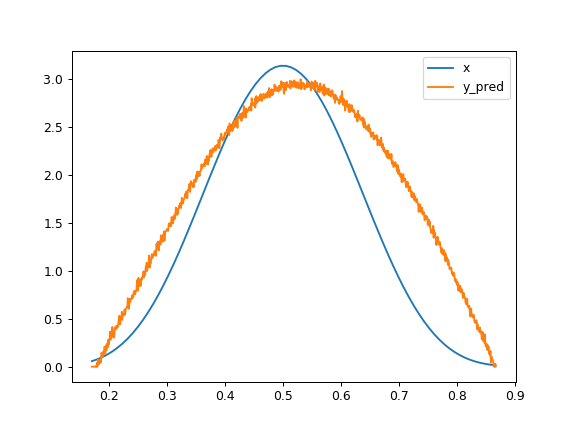

In [34]:
i = 7
distribution = distributions[i]
args = distrib_args[i]
lim = lims[i]
n = n_x[12]

x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
x_pdf = distribution.pdf(x_x,*args)
y_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n_y) 
y_pdf_true = distribution.pdf(y_x,*args)

decoder_in = np.zeros((x_pdf.shape[0],1,n_a))
x_pdf = x_pdf.reshape(1,x_pdf.size,1)
x_x = x_x.reshape(1, x_x.size, 1)
y_pdf_pred = model.predict(x=[x_pdf, x_x, decoder_in])

plt.figure()
plt.plot(x_x.flatten(), x_pdf.flatten(), label='x')
plt.plot(y_x, y_pdf_pred.flatten(), label='y_pred')
plt.legend()

In [ ]:
distribution = stats.powernorm
args = (1,)
lim = (10**-3,10**-3)
n = n_x[6]

x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
x_pdf = distribution.pdf(x_x,*args)
y_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n_y) 
y_pdf_true = distribution.pdf(y_x,*args)

decoder_in = np.zeros((x_pdf.shape[0],1,n_a))
x_pdf = x_pdf.reshape(1,x_pdf.size,1)
y_pdf_pred = model.predict(x=[x_pdf, decoder_in])

plt.figure()
plt.plot(x_x, x_pdf.flatten(), label='x')
plt.plot(y_x, y_pdf_pred.flatten(), label='y_pred')
plt.legend()